In [1]:
import pandas as pd

# Load the battery 1.1 (battery11.csv) file
df = pd.read_csv("../battery_alt_dataset/regular_alt_batteries/battery11.csv", low_memory=False)

# Convert 'start_time' to datetime object
df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')

# Create absolute timestamp by combining start_time + time
df['absolute_time'] = df['start_time'] + pd.to_timedelta(df['time'], unit='s')

# Force numeric conversion on temperature and voltage fields (in case of string corruption)
df['temperature_battery']   = pd.to_numeric(df['temperature_battery'], errors='coerce')
df['voltage_charger']       = pd.to_numeric(df['voltage_charger'], errors='coerce')
df['voltage_load']          = pd.to_numeric(df['voltage_load'], errors='coerce')
df['current_load']          = pd.to_numeric(df['current_load'], errors='coerce')
df['temperature_mosfet']    = pd.to_numeric(df['temperature_mosfet'], errors='coerce')
df['temperature_resistor']  = pd.to_numeric(df['temperature_resistor'], errors='coerce')

# Preview key columns
print(df[['start_time', 'time', 'absolute_time', 'temperature_battery']].head())


           start_time   time           absolute_time  temperature_battery
0 2022-08-09 13:31:00  0.000 2022-08-09 13:31:00.000                0.000
1 2022-08-09 13:31:00  0.644 2022-08-09 13:31:00.644               22.392
2 2022-08-09 13:31:00  1.570 2022-08-09 13:31:01.570               22.392
3 2022-08-09 13:31:00  2.496 2022-08-09 13:31:02.496               22.392
4 2022-08-09 13:31:00  3.423 2022-08-09 13:31:03.423               22.389



🔍 Analyzing: voltage_load
count    759722.000000
mean          6.690558
std           0.635927
min          -0.027000
25%           6.310000
50%           6.714000
75%           7.099000
max           8.748000
Name: voltage_load, dtype: float64


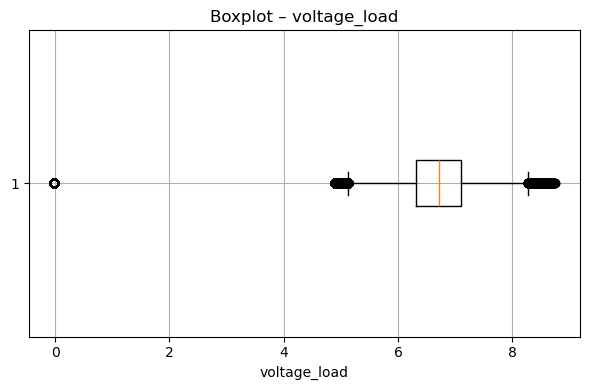


🔍 Analyzing: current_load
count    759722.000000
mean          8.454313
std           2.695369
min           0.150000
25%           9.315996
50%           9.675995
75%           9.791818
max          10.473503
Name: current_load, dtype: float64


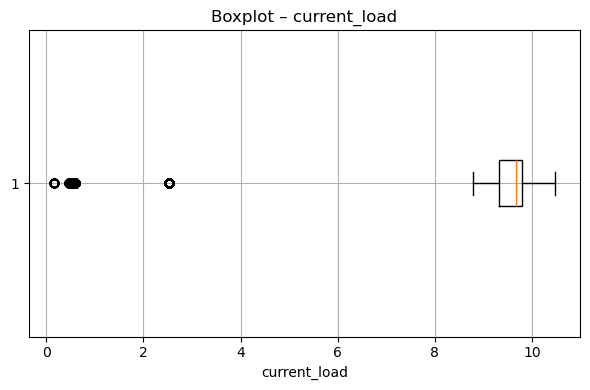


🔍 Analyzing: temperature_battery
count    4.914864e+06
mean     3.233844e+01
std      8.005960e+00
min      0.000000e+00
25%      2.729700e+01
50%      3.070300e+01
75%      3.387500e+01
max      6.402600e+01
Name: temperature_battery, dtype: float64


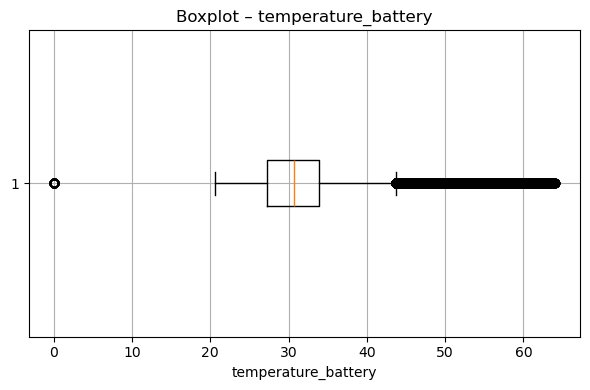

In [2]:
import matplotlib.pyplot as plt

# İncelenecek sütunlar
cols = ['voltage_load', 'current_load', 'temperature_battery']

for col in cols:
    print(f"\n🔍 Analyzing: {col}")
    print(df[col].describe())

    # Boxplot
    plt.figure(figsize=(6, 4))
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f"Boxplot – {col}")
    plt.xlabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [188]:
# Aykırı değerleri filtrele
df_clean = df.copy()

# 1. Gerilim negatif olanları at
df_clean = df_clean[df_clean['voltage_load'] >= 0]

# 2. Akım çok düşükse (örneğin < 1 A) → büyük ihtimalle noise
df_clean = df_clean[df_clean['current_load'] >= 1]

# 3. Batarya sıcaklığı 0 ise → geçersiz say
df_clean = df_clean[df_clean['temperature_battery'] > 0]

print(f"Veri temizliği sonrası satır sayısı: {df_clean.shape[0]}")


Veri temizliği sonrası satır sayısı: 757975


In [189]:
# Reference discharge (sadece temizlenmiş veriden)
df_ref = df_clean[(df_clean['mode'] == -1) & (df_clean['mission_type'] == 0)].copy()

# Zaman farkı > threshold ise yeni segment başlat
df_ref['delta'] = df_ref['time'].diff()
df_ref['segment'] = (df_ref['delta'] > 10).cumsum()

# Kaç segment var?
print(f"Toplam reference discharge segmenti: {df_ref['segment'].nunique()}")

# Örnek: İlk 5 satır
df_ref.head()


Toplam reference discharge segmenti: 43


,start_time,time,mode,voltage_charger,temperature_battery,voltage_load,current_load,temperature_mosfet,temperature_resistor,mission_type,absolute_time,delta,segment
922,2022-08-09 13:31:00,868.051,-1.0,8.215,22.584,8.497,2.521,28.33,30.34,0.0,2022-08-09 13:45:28.051,NaN,0
923,2022-08-09 13:31:00,869.004,-1.0,8.205,22.591,8.487,2.521,28.23,30.25,0.0,2022-08-09 13:45:29.004,0.953,0
924,2022-08-09 13:31:00,869.952,-1.0,8.198,22.603,8.479,2.521,28.14,30.15,0.0,2022-08-09 13:45:29.952,0.948,0
925,2022-08-09 13:31:00,870.915,-1.0,8.191,22.607,8.472,2.521,28.06,30.06,0.0,2022-08-09 13:45:30.915,0.963,0
926,2022-08-09 13:31:00,871.864,-1.0,8.185,22.611,8.466,2.521,27.97,29.96,0.0,2022-08-09 13:45:31.864,0.949,0


In [190]:
capacities = []

for seg_id, seg_df in df_ref.groupby('segment'):
    seg_df = seg_df.copy()
    seg_df['delta_t'] = seg_df['time'].diff().fillna(0)
    seg_df['energy'] = seg_df['current_load'] * seg_df['delta_t']
    capacity_ah = seg_df['energy'].sum() / 3600
    capacities.append((seg_id, capacity_ah))

# Yazdır
for seg_id, cap in capacities:
    print(f"Segment {seg_id:02d} – Capacity: {cap:.3f} Ah")


Segment 00 – Capacity: 2.453 Ah
Segment 01 – Capacity: 2.410 Ah
Segment 02 – Capacity: 2.373 Ah
Segment 03 – Capacity: 2.359 Ah
Segment 04 – Capacity: 2.333 Ah
Segment 05 – Capacity: 2.312 Ah
Segment 06 – Capacity: 2.284 Ah
Segment 07 – Capacity: 2.271 Ah
Segment 08 – Capacity: 2.251 Ah
Segment 09 – Capacity: 2.236 Ah
Segment 10 – Capacity: 2.219 Ah
Segment 11 – Capacity: 2.204 Ah
Segment 12 – Capacity: 2.190 Ah
Segment 13 – Capacity: 2.177 Ah
Segment 14 – Capacity: 2.161 Ah
Segment 15 – Capacity: 2.151 Ah
Segment 16 – Capacity: 2.139 Ah
Segment 17 – Capacity: 2.127 Ah
Segment 18 – Capacity: 2.103 Ah
Segment 19 – Capacity: 2.099 Ah
Segment 20 – Capacity: 2.085 Ah
Segment 21 – Capacity: 2.071 Ah
Segment 22 – Capacity: 2.061 Ah
Segment 23 – Capacity: 2.048 Ah
Segment 24 – Capacity: 2.029 Ah
Segment 25 – Capacity: 2.014 Ah
Segment 26 – Capacity: 2.013 Ah
Segment 27 – Capacity: 2.003 Ah
Segment 28 – Capacity: 1.988 Ah
Segment 29 – Capacity: 1.971 Ah
Segment 30 – Capacity: 1.967 Ah
Segment 

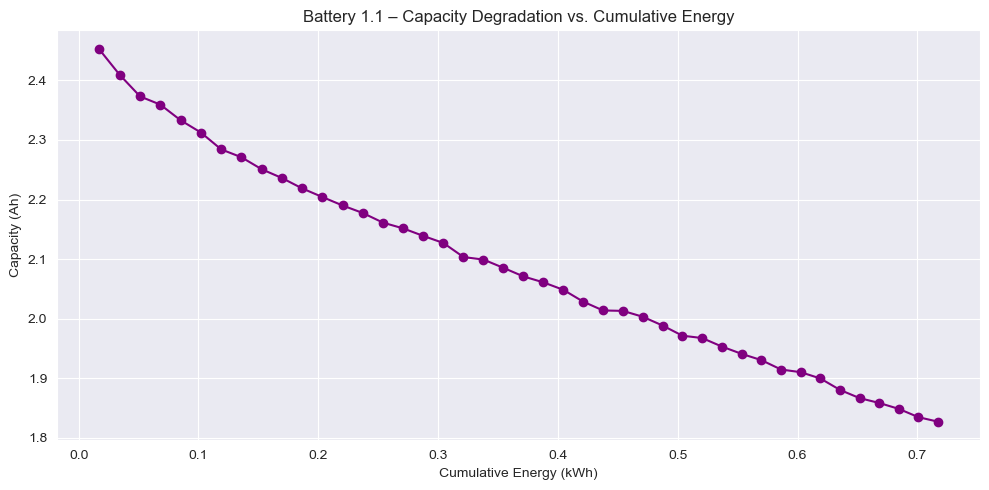

In [201]:
import matplotlib.pyplot as plt

# Calculate cumulative energy per reference discharge
# This assumes we have capacity data from the reference discharges
# and we need to estimate the cumulative energy up to each point

# First, calculate energy per normal discharge segment
segment_energies = []
for seg_id, seg_df in df_norm.groupby('segment'):
    seg_df = seg_df.copy()
    # Calculate time deltas
    seg_df['delta_t'] = seg_df['time'].diff().fillna(0)
    # Energy = voltage * current * time
    seg_df['energy_wh'] = seg_df['voltage_load'] * seg_df['current_load'] * seg_df['delta_t'] / 3600
    total_energy_wh = seg_df['energy_wh'].sum()
    segment_energies.append((seg_id, total_energy_wh))

# Accumulate energy
cumulative_energy_wh = 0
cumulative_energies = []
for seg_id, energy in segment_energies:
    cumulative_energy_wh += energy
    cumulative_energies.append((seg_id, cumulative_energy_wh))

# Convert to kWh for better readability
cumulative_energies_kwh = [(seg_id, energy / 1000) for seg_id, energy in cumulative_energies]

# Join with capacity data
# Interpolate cumulative energy to match with reference discharge points
# This is simplified - in practice you'd need to match the reference points with normal discharges
capacity_vs_energy = []
for i, (seg_id, capacity) in enumerate(capacities):
    if i < len(cumulative_energies_kwh):
        energy_kwh = cumulative_energies_kwh[i][1]
        capacity_vs_energy.append((energy_kwh, capacity))

# Plot capacity vs. cumulative energy
energy_values = [x[0] for x in capacity_vs_energy]
capacity_values = [x[1] for x in capacity_vs_energy]

plt.figure(figsize=(10, 5))
plt.plot(energy_values, capacity_values, marker='o', linestyle='-', color='purple')
plt.xlabel("Cumulative Energy (kWh)")
plt.ylabel("Capacity (Ah)")
plt.title("Battery 1.1 – Capacity Degradation vs. Cumulative Energy")
plt.grid(True)
plt.tight_layout()
plt.show()

In [192]:
# Normal görevler: mission_type == 1 ve discharge modu
df_norm = df_clean[(df_clean['mode'] == -1) & (df_clean['mission_type'] == 1)].copy()

# Zaman farkı ile segmentleri belirle
df_norm['delta'] = df_norm['time'].diff()
df_norm['segment'] = (df_norm['delta'] > 10).cumsum()

# Kaç görev var?
print(f"Normal discharge görev sayısı (segment): {df_norm['segment'].nunique()}")

# Örnek satırlara bakalım
df_norm.head()


Normal discharge görev sayısı (segment): 822


,start_time,time,mode,voltage_charger,temperature_battery,voltage_load,current_load,temperature_mosfet,temperature_resistor,mission_type,absolute_time,delta,segment
11503,2022-08-09 13:31:00,10955.839,-1.0,7.864,22.148,8.031,9.074002,22.02,22.19,1.0,2022-08-09 16:33:35.839,NaN,0
11504,2022-08-09 13:31:00,10956.788,-1.0,7.832,22.194,7.995,9.077866,22.06,22.19,1.0,2022-08-09 16:33:36.788,0.949,0
11505,2022-08-09 13:31:00,10957.736,-1.0,7.804,22.251,7.970,9.073229,22.14,22.19,1.0,2022-08-09 16:33:37.736,0.948,0
11506,2022-08-09 13:31:00,10958.685,-1.0,7.780,22.312,7.951,9.070910,22.25,22.20,1.0,2022-08-09 16:33:38.685,0.949,0
11507,2022-08-09 13:31:00,10959.636,-1.0,7.761,22.381,7.933,9.060084,22.40,22.21,1.0,2022-08-09 16:33:39.636,0.951,0


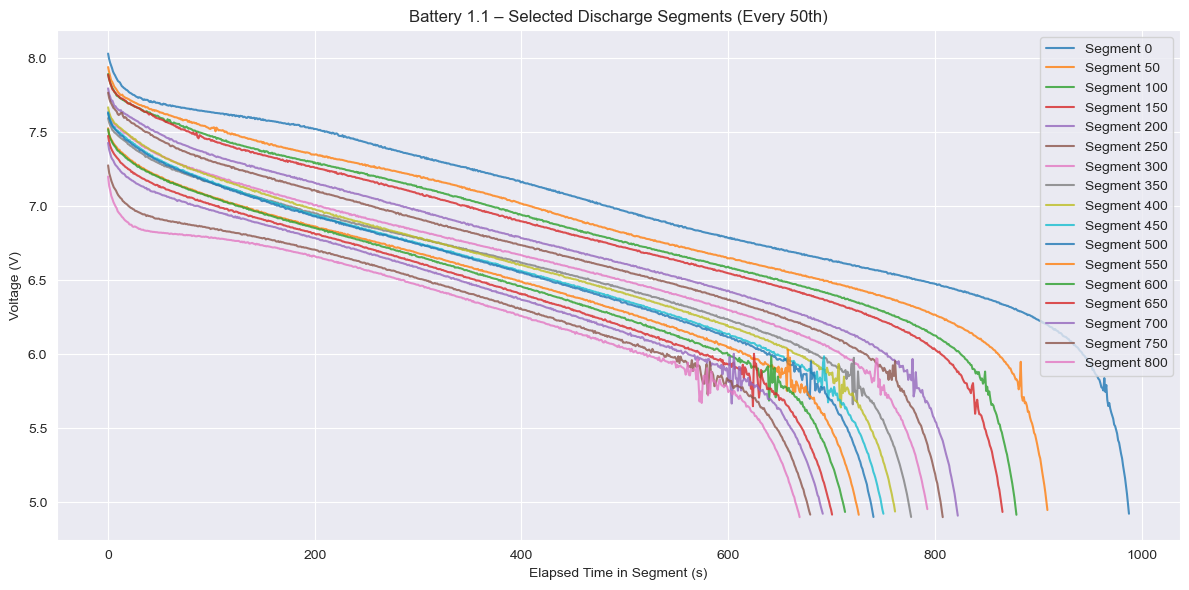

In [193]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot every Nth segment (e.g., every 50th segment)
step = 50

for seg_id, seg_df in df_norm.groupby('segment'):
    if seg_id % step == 0:  # Only plot if segment ID is divisible by step
        t0 = seg_df['time'].iloc[0]
        time_rel = seg_df['time'] - t0
        plt.plot(time_rel, seg_df['voltage_load'], alpha=0.8, label=f'Segment {seg_id}')

plt.xlabel("Elapsed Time in Segment (s)")
plt.ylabel("Voltage (V)")
plt.title(f"Battery 1.1 – Selected Discharge Segments (Every {step}th)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [194]:
# Her normal segment için süreyi hesapla
durations = []

for seg_id, seg_df in df_norm.groupby('segment'):
    t_start = seg_df['time'].iloc[0]
    t_end = seg_df['time'].iloc[-1]
    duration = t_end - t_start
    durations.append((seg_id, duration))

# Yazdır
for seg_id, d in durations[:10]:
    print(f"Segment {seg_id:02d} – Duration: {d:.2f} s")

print(f"\nToplam {len(durations)} segment analiz edildi.")


Segment 00 – Duration: 987.80 s
Segment 01 – Duration: 990.78 s
Segment 02 – Duration: 990.56 s
Segment 03 – Duration: 939.76 s
Segment 04 – Duration: 942.79 s
Segment 05 – Duration: 943.97 s
Segment 06 – Duration: 942.74 s
Segment 07 – Duration: 940.87 s
Segment 08 – Duration: 944.32 s
Segment 09 – Duration: 942.63 s

Toplam 822 segment analiz edildi.


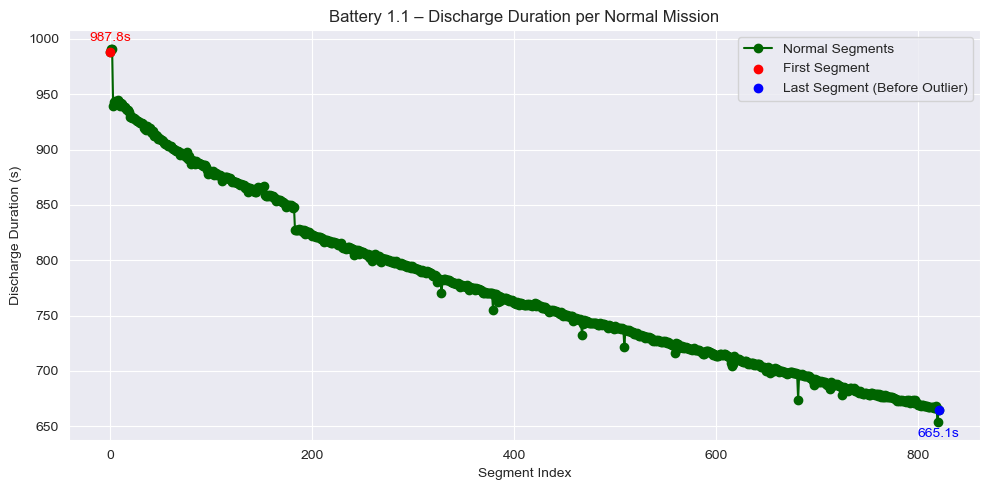

In [195]:
import matplotlib.pyplot as plt

# Segment numaraları ve süre değerlerini ayır, son segmenti çıkar
segment_ids = [x[0] for x in durations[:-1]]
segment_durations = [x[1] for x in durations[:-1]]

# Grafik
plt.figure(figsize=(10, 5))
plt.plot(segment_ids, segment_durations, marker='o', linestyle='-', color='darkgreen', label='Normal Segments')

# İlk noktayı vurgula
plt.scatter(segment_ids[0], segment_durations[0], color='red', zorder=5, label='First Segment')
plt.text(segment_ids[0], segment_durations[0]+10, f"{segment_durations[0]:.1f}s", ha='center', color='red')

# Son noktayı vurgula (821 hariç tutulduğu için -1 indeks)
plt.scatter(segment_ids[-1], segment_durations[-1], color='blue', zorder=5, label='Last Segment (Before Outlier)')
plt.text(segment_ids[-1], segment_durations[-1]-25, f"{segment_durations[-1]:.1f}s", ha='center', color='blue')

plt.xlabel("Segment Index")
plt.ylabel("Discharge Duration (s)")
plt.title("Battery 1.1 – Discharge Duration per Normal Mission")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🔍 Bu grafikte Battery 1.1’in her bir discharge görevinde ne kadar süre çalıştığı gösterilmektedir. İlk segment (0) en uzun süreli discharge işlemini temsil ederken, sonlara doğru kademeli azalma görülmektedir. Son segment olan 821 numaralı discharge görevi aykırı değer olarak tespit edilmiş ve grafikten çıkarılmıştır. Bu noktada bataryanın ciddi performans kaybı yaşadığı anlaşılmaktadır.

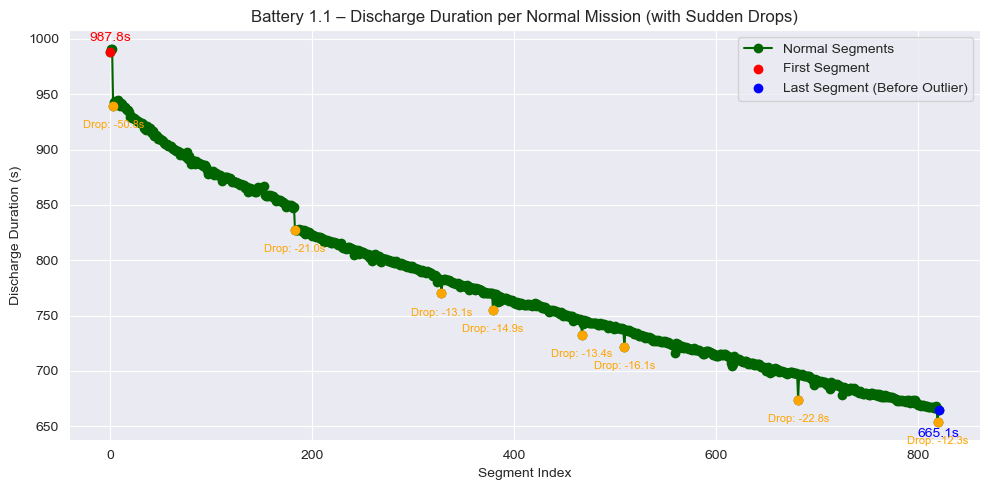

⚠️ Sudden drop at segment 3: Δ-50.8s
⚠️ Sudden drop at segment 183: Δ-21.0s
⚠️ Sudden drop at segment 328: Δ-13.1s
⚠️ Sudden drop at segment 379: Δ-14.9s
⚠️ Sudden drop at segment 467: Δ-13.4s
⚠️ Sudden drop at segment 509: Δ-16.1s
⚠️ Sudden drop at segment 681: Δ-22.8s
⚠️ Sudden drop at segment 819: Δ-12.3s


In [196]:
import matplotlib.pyplot as plt
import numpy as np

# Ani düşüş eşiği (örneğin bir segmentte 10 saniyeden fazla düşüş olursa şüpheli)
drop_threshold = -10

# Farkları hesapla
diffs = np.diff(segment_durations)
sudden_drop_indices = [i+1 for i, d in enumerate(diffs) if d < drop_threshold]

# Grafik
plt.figure(figsize=(10, 5))
plt.plot(segment_ids, segment_durations, marker='o', linestyle='-', color='darkgreen', label='Normal Segments')

# İlk ve son noktayı vurgula
plt.scatter(segment_ids[0], segment_durations[0], color='red', zorder=5, label='First Segment')
plt.text(segment_ids[0], segment_durations[0]+10, f"{segment_durations[0]:.1f}s", ha='center', color='red')
plt.scatter(segment_ids[-1], segment_durations[-1], color='blue', zorder=5, label='Last Segment (Before Outlier)')
plt.text(segment_ids[-1], segment_durations[-1]-25, f"{segment_durations[-1]:.1f}s", ha='center', color='blue')

# Ani düşüşleri işaretle
for idx in sudden_drop_indices:
    plt.scatter(segment_ids[idx], segment_durations[idx], color='orange', zorder=6)
    plt.text(segment_ids[idx], segment_durations[idx]-20, f"Drop: {diffs[idx-1]:.1f}s", ha='center', color='orange', fontsize=8)

plt.xlabel("Segment Index")
plt.ylabel("Discharge Duration (s)")
plt.title("Battery 1.1 – Discharge Duration per Normal Mission (with Sudden Drops)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# İstersen çıktısını yazdıralım
for idx in sudden_drop_indices:
    print(f"⚠️ Sudden drop at segment {segment_ids[idx]}: Δ{diffs[idx-1]:.1f}s")


Not: Discharge süresindeki ani düşüşler (örn. Segment 3’te) test protokolünde uygulanan yüksek akım seviyeleri (≥4C) nedeniyle ani voltaj düşüşü sonucu oluşmuştur. Bu durum özellikle erken segmentlerde daha belirgindir ve bataryanın iç parametrelerindeki (qmax, Rb) hızlı değişimle ilişkilidir. Ayrıca, bazı segmentlerin erken sonlanıp diğerlerinin aynı seviyeden devam etmesi, farklı akım ve sıcaklık koşullarının batarya davranışını etkilemesinden kaynaklanır. Bu gözlemler veri setini yayınlayan araştırma ekibi tarafından da beklenen sonuçlar olarak açıklanmıştır.

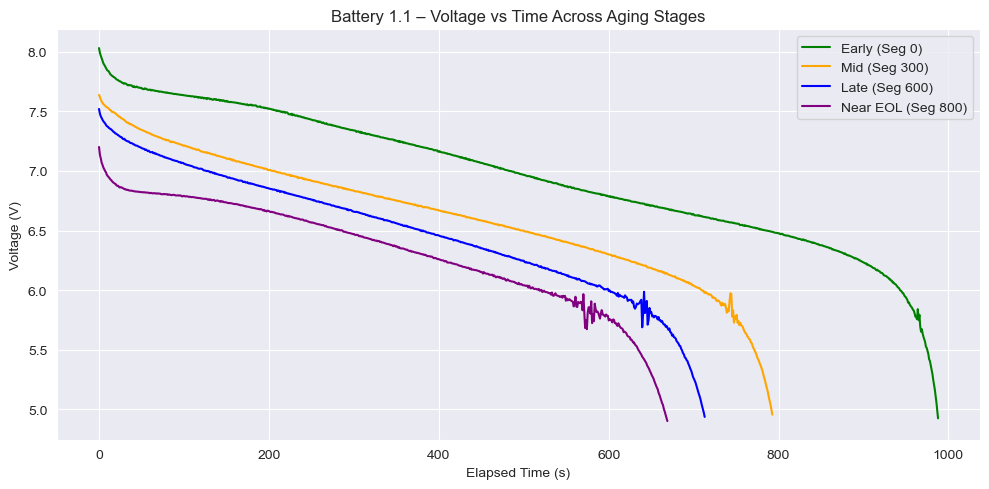

In [197]:
import matplotlib.pyplot as plt

# Seçilen segment ID’leri (Early, Mid, Late, Near EOL)
selected_ids = [0, 300, 600, 800]
colors = ['green', 'orange', 'blue', 'purple']
labels = ['Early (Seg 0)', 'Mid (Seg 300)', 'Late (Seg 600)', 'Near EOL (Seg 800)']

plt.figure(figsize=(10, 5))

for i, seg_id in enumerate(selected_ids):
    seg_df = df_norm[df_norm['segment'] == seg_id]
    if seg_df.empty:
        continue  # segment yoksa atla
    elapsed_time = seg_df['time'] - seg_df['time'].iloc[0]
    plt.plot(elapsed_time, seg_df['voltage_load'], label=labels[i], color=colors[i])

plt.xlabel("Elapsed Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Battery 1.1 – Voltage vs Time Across Aging Stages")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🔎 Gözlem: 600. ve 800. segmentlerde (geç dönem ve EOL’e yakın) voltaj-zaman eğrisinin sonlarında belirgin bir titreşim (yüksek frekanslı salınım) gözlemlenmektedir. Bu dalgalanmalar, hücrenin iç direncinin arttığını ve özellikle düşük şarj seviyelerinde ya da sabit yük altında terminal voltajının kararsızlaştığını göstermektedir.

⚠️ Teknik Açıklama: Lityum-iyon pillerin yaşlanmasıyla birlikte anot-katot arayüzlerinde bozulmalar ve SEI tabakasının kalınlaşması gibi kimyasal süreçler hücre iç direncini artırır. Bu durum, özellikle boşalmanın son evresinde voltajda gürültü ve ani düşüşler olarak kendini gösterir. Böyle bir davranış, hücrenin güç performansında azalma ve termal kararsızlık riski açısından uyarıcı niteliktedir.

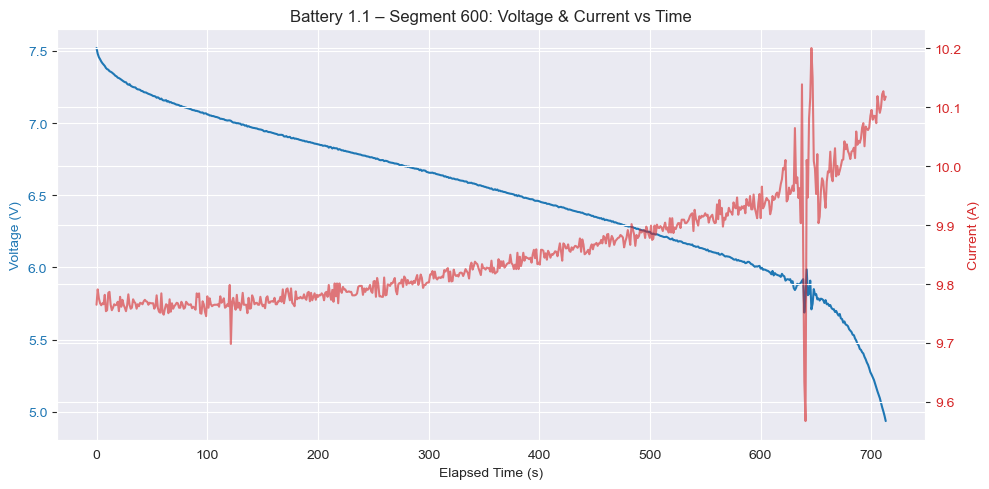

In [198]:
import matplotlib.pyplot as plt

# Segment 600'ü al
seg_id = 600
seg_df = df_norm[df_norm['segment'] == seg_id]

# Zamanı normalize et
elapsed_time = seg_df['time'] - seg_df['time'].iloc[0]

# Grafik
fig, ax1 = plt.subplots(figsize=(10, 5))

# Voltaj ekseni
ax1.plot(elapsed_time, seg_df['voltage_load'], color='tab:blue', label='Voltage (V)')
ax1.set_xlabel("Elapsed Time (s)")
ax1.set_ylabel("Voltage (V)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Akım ekseni
ax2 = ax1.twinx()
ax2.plot(elapsed_time, seg_df['current_load'], color='tab:red', alpha=0.6, label='Current (A)')
ax2.set_ylabel("Current (A)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Başlık ve grid
plt.title("Battery 1.1 – Segment 600: Voltage & Current vs Time")
fig.tight_layout()
plt.grid(True)
plt.show()


📌 Not: Segment 600’de, zamanla artan yük altında batarya voltajı kademeli olarak düşerken, akım davranışı oldukça kararsız bir hal almıştır.
🔁 Özellikle son bölümdeki akım artışları ve ani voltaj düşüşleri, yaşlanan hücrelerde iç direnç artışının ve kontrol istikrarsızlığının göstergesidir.
⚠️ Bu gibi durumlar, bataryanın ileri yaş dönemlerinde termal kaçak, ani boşalma, ya da ani kapasite kaybı risklerini artırabilir.

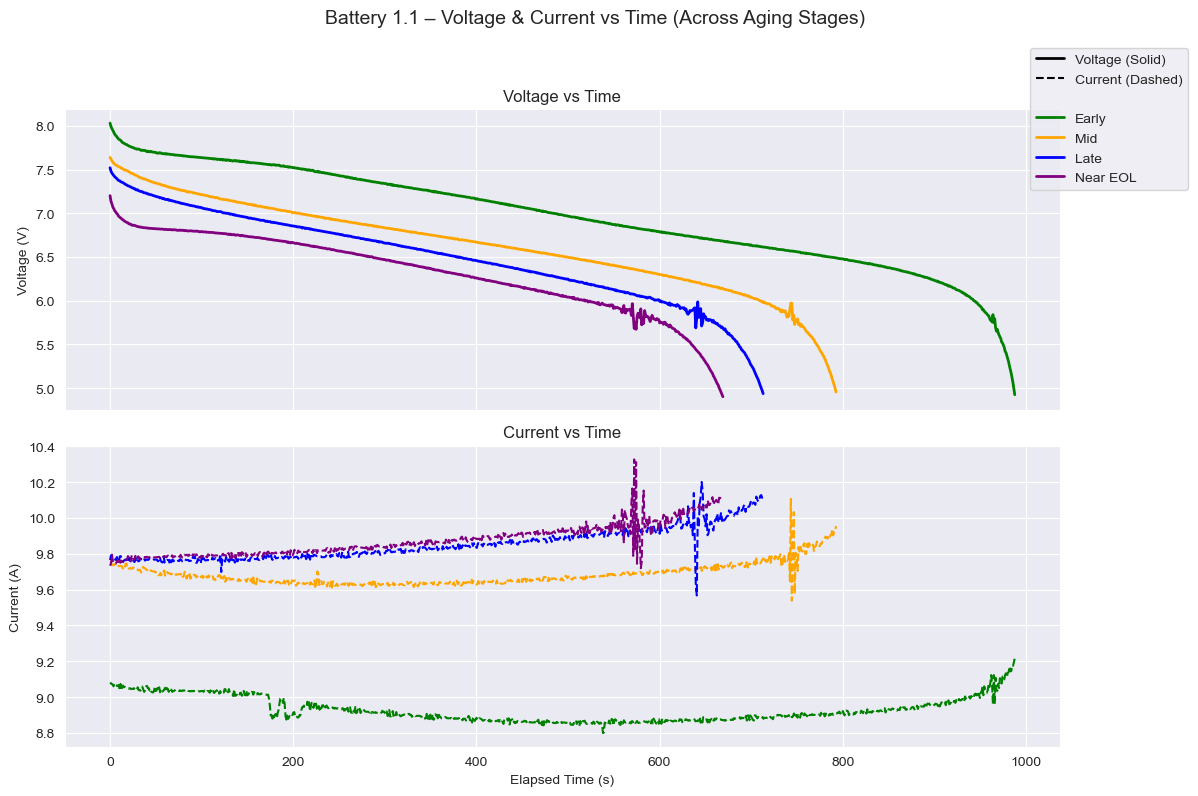

In [199]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # Needed for custom legend
# Assuming 'df_norm' is your pandas DataFrame and is already loaded

# Karşılaştırmak istediğin segmentleri belirt (Segments to compare)
# Using a list of tuples might be slightly clearer for iteration
segments_to_plot = [
    (0, "Early", 'green'),
    (300, "Mid", 'orange'),
    (600, "Late", 'blue'),
    (800, "Near EOL", 'purple')
]

# --- Create Figure with Two Subplots ---
# nrows=2 for two plots vertically, sharex=True to link time axes
# Adjust figsize for better vertical space
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

# Define column names (makes code easier to read/modify)
time_col = 'time'
voltage_col = 'voltage_load'
current_col = 'current_load'
segment_col = 'segment'

# --- Plotting Loop (Iterate once) ---
for seg_id, label, color in segments_to_plot:
    # Filter data for the current segment
    # Use .copy() to avoid potential SettingWithCopyWarning later
    seg_df = df_norm[df_norm[segment_col] == seg_id].copy()

    if seg_df.empty:
        print(f"Warning: No data for segment {seg_id} ({label}). Skipping.")
        continue

    # Calculate elapsed time relative to the start of *this* segment
    # Using .loc ensures correct calculation even if index isn't sequential
    elapsed_time = seg_df[time_col] - seg_df[time_col].iloc[0]

    # Plot Voltage on the top subplot (axes[0])
    axes[0].plot(elapsed_time, seg_df[voltage_col],
                 color=color,
                 linewidth=2,
                 label=label) # Label used for legend later

    # Plot Current on the bottom subplot (axes[1])
    # Kept linestyle and original alpha, adjust alpha if needed (0.5 might be quite faint)
    axes[1].plot(elapsed_time, seg_df[current_col],
                 color=color,
                 linestyle='--',
                 # alpha=0.5, # Consider removing or increasing alpha if dashed lines are hard to see
                 label=label) # Label used for legend later


# --- Configure Subplots ---

# Top Subplot (Voltage)
axes[0].set_ylabel("Voltage (V)")
axes[0].grid(True)
axes[0].set_title("Voltage vs Time") # Add subplot title

# Bottom Subplot (Current)
axes[1].set_ylabel("Current (A)")
axes[1].set_xlabel("Elapsed Time (s)") # X-label only needed on the bottom shared axis
axes[1].grid(True)
axes[1].set_title("Current vs Time") # Add subplot title

# --- Create a Clearer, Unified Legend ---
# We'll create custom legend elements to explain color and line style

legend_elements = [
    # Explain line styles
    Line2D([0], [0], color='black', lw=2, label='Voltage (Solid)'),
    Line2D([0], [0], color='black', lw=1.5, linestyle='--', label='Current (Dashed)'),
    # Add spacer (optional, empty Line2D)
    Line2D([0], [0], marker='None', color='None', label=''),
    # Explain colors (Stages)
]
# Add color indicators based on your segments
for seg_id, label, color in segments_to_plot:
     legend_elements.append(Line2D([0], [0], color=color, lw=2, label=label))

# Place legend outside the plot area for clarity
# Adjust bbox_to_anchor x-value (e.g., 1.15) and potentially fig.tight_layout(rect=...)
# if the legend overlaps the plot. Start with loc='upper right'.
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.0, 0.95))


# --- Final Touches ---
# Use suptitle for the overall figure title
fig.suptitle("Battery 1.1 – Voltage & Current vs Time (Across Aging Stages)", fontsize=14, y=0.99)

# Adjust layout - rect might be needed if fig.legend overlaps axes
# rect=[left, bottom, right, top] values are fractions of the figure width/height
fig.tight_layout(rect=[0, 0, 0.9, 0.95]) # Leave space top for suptitle, right for legend

plt.show()

Bu grafik, bataryanın yaşlanma sürecindeki dört farklı segmentteki (Erken, Orta, Geç, EOL’a Yakın) gerilim (voltaj) ve akım (current) değişimlerini karşılaştırmalı olarak göstermektedir.

Gerilim eğrileri (üstteki grafik): Yaşlanma ile birlikte bataryanın deşarj süresi kısalmakta ve voltaj daha erken düşmektedir. Özellikle EOL’a (End-of-Life) yakın segmentlerde gerilim eğrisi hem daha erken sona ermektedir hem de deşarj sürecinin ortalarında daha dik bir düşüş göstermektedir. Bu, batarya kapasitesinin azaldığını ve iç dirençte artış olduğunu gösterir.

Akım profilleri (alttaki grafik): Akım sabit görünse de yaşlanan bataryalarda küçük dalgalanmalar (özellikle geç ve EOL’a yakın segmentlerde) gözlenmektedir. Bu durum, bataryanın yük tepkisinde kararsızlık oluştuğunu ve hücrelerin dinamik davranışının bozulduğunu düşündürür.

Voltaj-Akım uyumu: Özellikle segment 600 ve 800’de, akımdaki küçük artışlara karşı voltajda daha hızlı düşüş gözlenmekte, bu da hücrelerin yaşlandıkça daha zayıf bir tepki verdiğini göstermektedir.



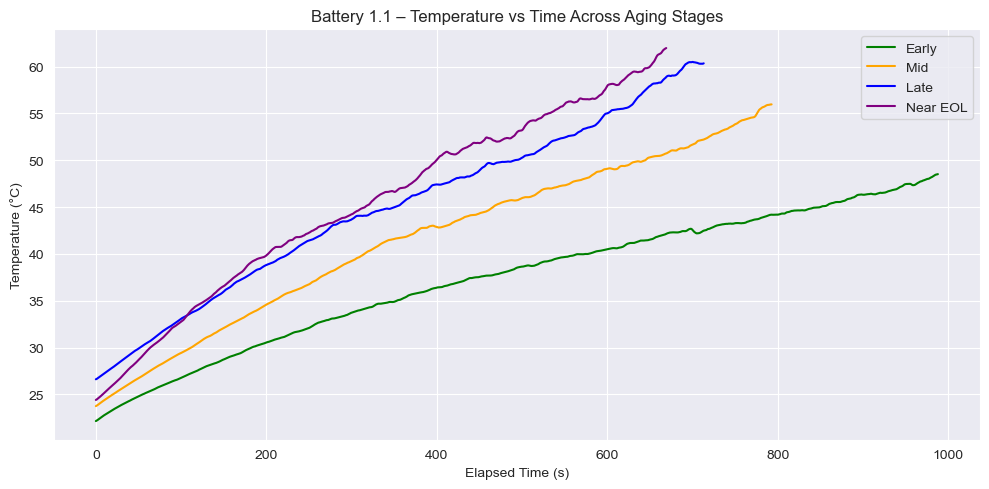

In [200]:
import matplotlib.pyplot as plt

# İncelenecek segmentler
segments = [0, 300, 600, 800]
colors = ['green', 'orange', 'blue', 'purple']
labels = ['Early', 'Mid', 'Late', 'Near EOL']

plt.figure(figsize=(10, 5))

# Her segmentin sıcaklık verisini çiz
for seg_id, color, label in zip(segments, colors, labels):
    seg_df = df_norm[df_norm['segment'] == seg_id]
    elapsed_time = seg_df['time'] - seg_df['time'].iloc[0]
    plt.plot(elapsed_time, seg_df['temperature_battery'], label=label, color=color)

plt.xlabel("Elapsed Time (s)")
plt.ylabel("Temperature (°C)")
plt.title("Battery 1.1 – Temperature vs Time Across Aging Stages")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


R_init: 0.01005
R_min: 0.00511
R_now: 0.01293
R_norm: 1.52904
R_slope: 0.00009
R_min_idx: 212
R_area: 3.31214
R_above_thresh: 0


/var/folders/tp/c04r6psx0w9cn41_w3lfjky00000gn/T/ipykernel_66957/1158556803.py:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  R_area = np.trapz(resistance_values_np - R_min)


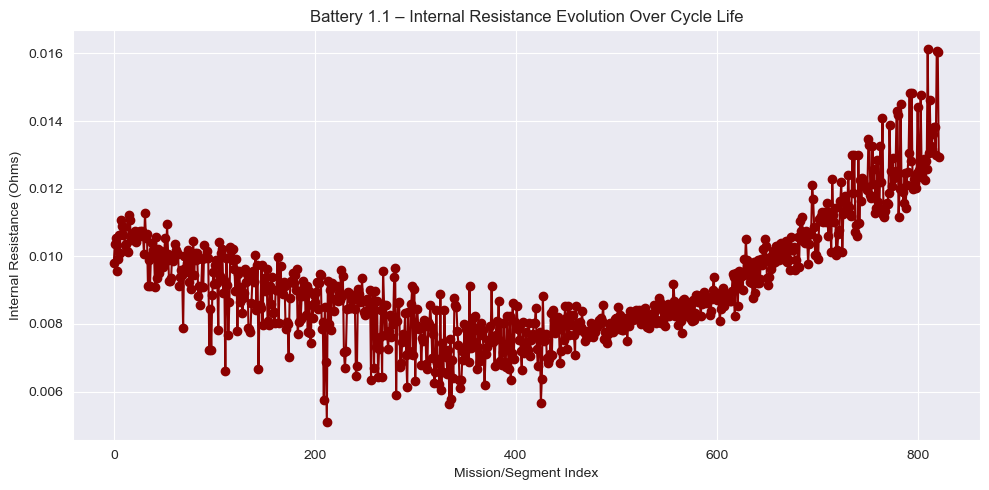

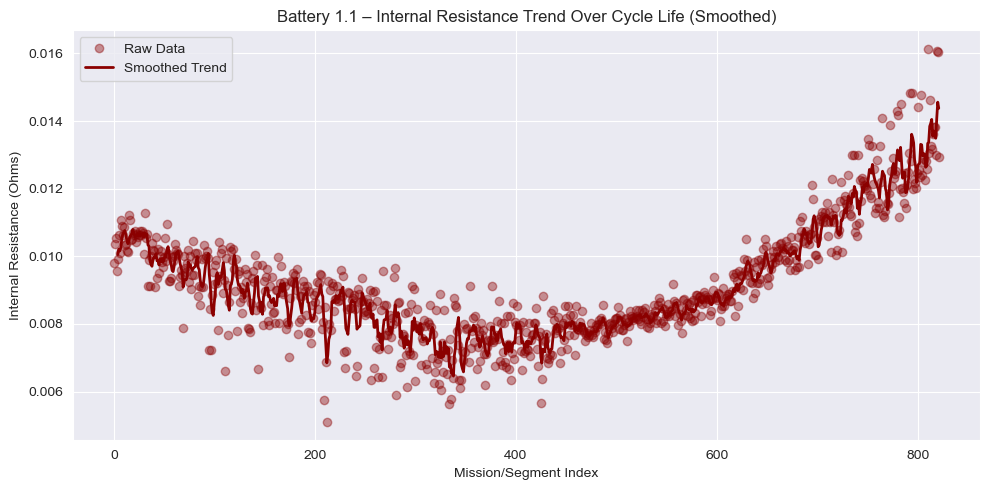

In [203]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Function to calculate internal resistance from voltage drop at discharge start
def calculate_internal_resistance(segment_df):
    """
    Calculate internal resistance using the initial voltage drop method:
    R = ΔV/I where ΔV is the initial voltage drop when current is applied

    This follows the concept in Paper 1, Section 4 about internal resistance (Ro)
    """
    if len(segment_df) < 5:
        return None

    initial_voltage = segment_df['voltage_load'].iloc[0]
    dropped_voltage = segment_df['voltage_load'].iloc[3:5].mean()
    avg_current = segment_df['current_load'].iloc[3:5].mean()

    if avg_current > 1.0:
        resistance = (initial_voltage - dropped_voltage) / avg_current
        return resistance
    return None


# Calculate resistance for each normal discharge segment
resistances = []

for seg_id, seg_df in df_norm.groupby('segment'):
    if len(seg_df) > 10:
        resistance = calculate_internal_resistance(seg_df)
        if resistance is not None and 0 < resistance < 1.0:
            resistances.append((seg_id, resistance))

# Convert to arrays for plotting and feature calculation
segment_ids = [x[0] for x in resistances]
resistance_values = [x[1] for x in resistances]
resistance_values_np = np.array(resistance_values)

# === FEATURE EXTRACTION START ===
R_init = np.mean(resistance_values_np[:5])
R_min = np.min(resistance_values_np)
R_now = resistance_values_np[-1]
R_norm = (R_now - R_min) / R_min
R_slope = linregress(segment_ids[-20:], resistance_values_np[-20:]).slope if len(resistance_values_np) >= 20 else None
R_min_idx = segment_ids[np.argmin(resistance_values_np)]
R_area = np.trapezoid(resistance_values_np - R_min)
R_above_thresh = int(R_now > 0.015)

battery_features = {
    'R_init': R_init,
    'R_min': R_min,
    'R_now': R_now,
    'R_norm': R_norm,
    'R_slope': R_slope,
    'R_min_idx': R_min_idx,
    'R_area': R_area,
    'R_above_thresh': R_above_thresh
}
# === FEATURE EXTRACTION END ===

# Print features (optional)
for k, v in battery_features.items():
    print(f"{k}: {v:.5f}" if isinstance(v, float) else f"{k}: {v}")

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(segment_ids, resistance_values, marker='o', linestyle='-', color='darkred')
plt.xlabel("Mission/Segment Index")
plt.ylabel("Internal Resistance (Ohms)")
plt.title("Battery 1.1 – Internal Resistance Evolution Over Cycle Life")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Plot with smoothing to see the trend better
plt.figure(figsize=(10, 5))
window_size = 5
smoothed_resistance = np.convolve(
    resistance_values, np.ones(window_size) / window_size, mode='valid'
)
smoothed_x = segment_ids[window_size - 1:]
plt.plot(segment_ids, resistance_values, 'o', alpha=0.4, color='darkred', label='Raw Data')
plt.plot(smoothed_x, smoothed_resistance, '-', linewidth=2, color='darkred', label='Smoothed Trend')
plt.xlabel("Mission/Segment Index")
plt.ylabel("Internal Resistance (Ohms)")
plt.title("Battery 1.1 – Internal Resistance Trend Over Cycle Life (Smoothed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Calculating internal resistance for normal cycles...
Calculated resistance for 822 segments.

--- Calculated Resistance Features ---
R_init: 0.01005
R_min: 0.00511
R_now: 0.01293
R_norm: 1.52904
R_slope: 0.00009
R_min_idx: 212
R_area: 3.31214
R_above_thresh: 0
--- End Features ---

Plotting Resistance vs Normal Segment Index...


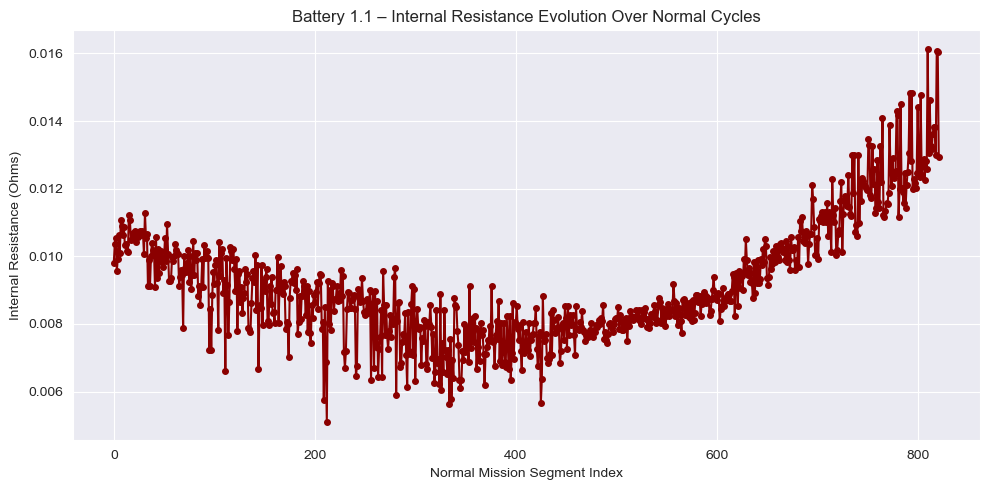

Plotting Smoothed Resistance vs Normal Segment Index...


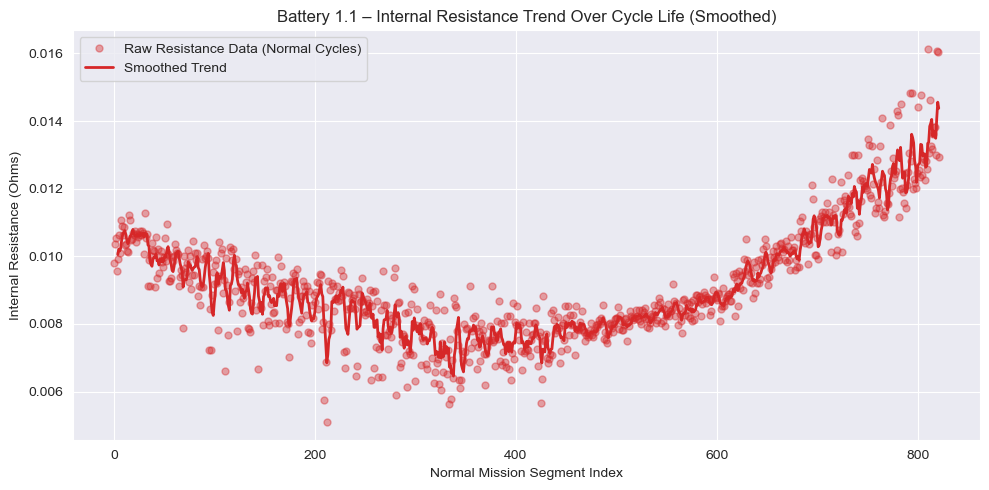


Aligning resistance with capacity data...
Processed 822 resistance points. Found 821 aligned capacity/resistance pairs.
Plotting Resistance vs Capacity...


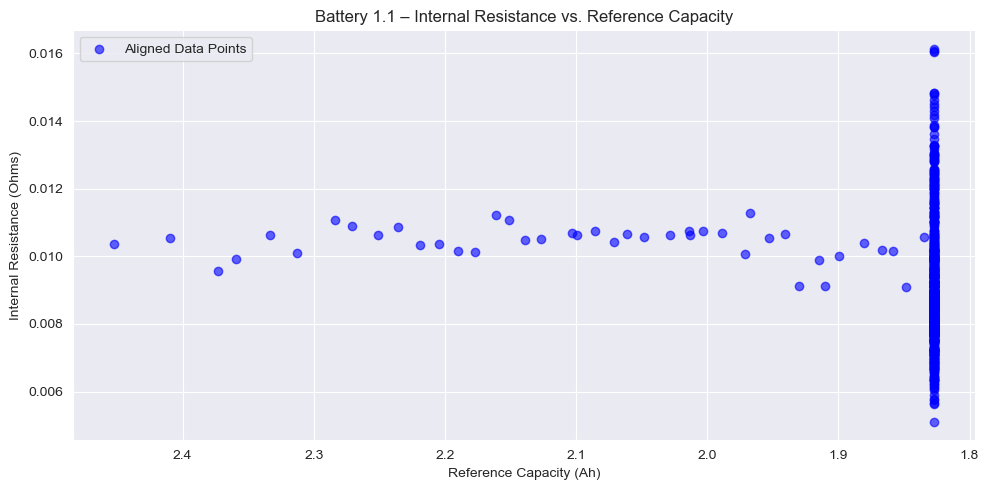

In [206]:
 # %% [NEW Cell: Internal Resistance Calculation and Plotting]
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import pandas as pd # Make sure pandas is imported

# --- Ensure df_norm and capacities are available from previous cells ---
if 'df_norm' not in locals() or df_norm.empty:
    print("Error: df_norm is not defined or is empty. Please run Cell 8 first.")
    # Add dummy data to prevent errors in subsequent lines if needed for testing
    # df_norm = pd.DataFrame(columns=['segment', 'time', 'voltage_load', 'current_load']) # Example dummy
elif 'capacities' not in locals() or not capacities:
     print("Error: capacities list is not defined or is empty. Please run Cell 6 first.")
     # capacities = [] # Example dummy

# --- Function to calculate internal resistance (from your code) ---
def calculate_internal_resistance(segment_df):
    """
    Calculate internal resistance using the initial voltage drop method.
    R = ΔV/I where ΔV is the initial voltage drop when current is applied.
    Uses average of readings at index 3 and 4 to get stabilized values.
    """
    # Ensure segment is sorted by time
    segment_df = segment_df.sort_values(by='time')

    if len(segment_df) < 5: # Need at least 5 points for iloc[0] and iloc[3:5]
        return None

    # Use .iloc for integer position indexing
    # Ensure columns exist and handle potential NaNs from conversions
    try:
        initial_voltage = float(segment_df['voltage_load'].iloc[0])
        # Take mean of 2 points after initial drop/noise
        dropped_voltage = segment_df['voltage_load'].iloc[3:5].astype(float).mean()
        avg_current = segment_df['current_load'].iloc[3:5].astype(float).mean()
    except (ValueError, TypeError, IndexError):
         # Handle cases where conversion to float fails or index is out of bounds
         return None

    # Check for NaN results from mean() if inputs were NaN
    if pd.isna(dropped_voltage) or pd.isna(avg_current):
        return None

    # Calculate resistance only if current is significant
    if avg_current > 1.0: # Using 1.0 as a threshold for valid load current
        resistance = (initial_voltage - dropped_voltage) / avg_current
        # Basic sanity check for plausible resistance values
        if 0 < resistance < 1.0: # Added upper bound (1 Ohm seems high, adjust if needed)
            return resistance
    return None

# --- Calculate resistance for each normal discharge segment ---
print("\nCalculating internal resistance for normal cycles...")
resistances = []
grouped_norm = df_norm.groupby('segment') # Group once

for seg_id, seg_df in grouped_norm:
    # Check segment length before processing
    if len(seg_df) > 10: # Keep threshold from your code
        resistance = calculate_internal_resistance(seg_df)
        if resistance is not None:
            resistances.append((seg_id, resistance))

print(f"Calculated resistance for {len(resistances)} segments.")

# --- Prepare data for plotting ---
if resistances:
    segment_ids_norm = np.array([x[0] for x in resistances]) # Normal cycle IDs
    resistance_values = np.array([x[1] for x in resistances])
else:
    print("No valid resistance values were calculated.")
    segment_ids_norm = np.array([])
    resistance_values = np.array([])


# === FEATURE EXTRACTION START (from your code) ===
# Add checks for sufficient data points before calculating features
if len(resistance_values) >= 5: # Need at least 5 for R_init
    R_init = np.mean(resistance_values[:5])
    R_min = np.min(resistance_values)
    R_now = resistance_values[-1]
    R_norm = (R_now - R_min) / R_min if R_min != 0 else np.nan # Avoid division by zero
    R_min_idx_loc = np.argmin(resistance_values)
    R_min_idx = segment_ids_norm[R_min_idx_loc] if R_min_idx_loc < len(segment_ids_norm) else np.nan # Use segment ID
    R_area = np.trapezoid(resistance_values - R_min) if len(resistance_values) > 1 else 0
    R_above_thresh = int(R_now > 0.015)

    if len(resistance_values) >= 20: # Need at least 20 for slope
        R_slope = linregress(segment_ids_norm[-20:], resistance_values[-20:]).slope
    else:
        R_slope = None # Not enough data for slope

    battery_features = {
        'R_init': R_init,
        'R_min': R_min,
        'R_now': R_now,
        'R_norm': R_norm,
        'R_slope': R_slope,
        'R_min_idx': R_min_idx, # Segment ID where minimum occurred
        'R_area': R_area,
        'R_above_thresh': R_above_thresh
    }

    print("\n--- Calculated Resistance Features ---")
    for k, v in battery_features.items():
        print(f"{k}: {v:.5f}" if isinstance(v, (float, np.float64)) and v is not None else f"{k}: {v}")
    print("--- End Features ---")

else:
    print("\nNot enough resistance data points to calculate features.")
    battery_features = {}
# === FEATURE EXTRACTION END ===


# --- Plot 1: Resistance vs. Segment Index (Normal Cycles) ---
if len(segment_ids_norm) > 0:
    print("\nPlotting Resistance vs Normal Segment Index...")
    plt.figure(figsize=(10, 5))
    plt.plot(segment_ids_norm, resistance_values, marker='o', linestyle='-', markersize=4, color='darkred')
    plt.xlabel("Normal Mission Segment Index")
    plt.ylabel("Internal Resistance (Ohms)")
    plt.title("Battery 1.1 – Internal Resistance Evolution Over Normal Cycles")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: Plot with smoothing
    if len(resistance_values) >= 5: # Need enough points for smoothing window
        print("Plotting Smoothed Resistance vs Normal Segment Index...")
        plt.figure(figsize=(10, 5))
        window_size = 5
        # Ensure window size is not larger than data
        window_size = min(window_size, len(resistance_values))
        smoothed_resistance = np.convolve(
            resistance_values, np.ones(window_size) / window_size, mode='valid'
        )
        # Adjust x-axis for smoothed data
        smoothed_x = segment_ids_norm[window_size - 1:]

        plt.plot(segment_ids_norm, resistance_values, 'o', alpha=0.4, markersize=5, color='#d62728', label='Raw Resistance Data (Normal Cycles)') # Adjusted color
        plt.plot(smoothed_x, smoothed_resistance, '-', linewidth=2, color='#d62728', label='Smoothed Trend') # Adjusted color
        plt.xlabel("Normal Mission Segment Index")
        plt.ylabel("Internal Resistance (Ohms)")
        plt.title("Battery 1.1 – Internal Resistance Trend Over Cycle Life (Smoothed)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
else:
    print("No resistance data to plot vs segment index.")


# --- Plot 2: Resistance vs. Capacity ---

# Create a mapping from reference segment ID to capacity
if capacities:
    capacity_map = dict(capacities)
    # Get sorted reference segment IDs
    ref_segment_ids_sorted = sorted(capacity_map.keys())
else:
    capacity_map = {}
    ref_segment_ids_sorted = []

# Align resistance data with the *most recent* capacity data
aligned_resistance = []
aligned_capacity = []

if capacity_map and len(segment_ids_norm) > 0:
    print("\nAligning resistance with capacity data...")
    processed_segments = 0
    aligned_pairs = 0
    for i, norm_seg_id in enumerate(segment_ids_norm):
        processed_segments += 1
        # Find the largest ref_seg_id that is smaller than the current norm_seg_id
        # Use binary search (or simple loop for moderate sizes) for efficiency if needed
        # Simple loop approach:
        relevant_ref_seg_id = None
        for ref_seg_id in ref_segment_ids_sorted:
            if ref_seg_id < norm_seg_id:
                relevant_ref_seg_id = ref_seg_id
            else:
                # Since IDs are sorted, we can stop once ref_seg_id >= norm_seg_id
                break

        # If we found a preceding reference cycle, pair the data
        if relevant_ref_seg_id is not None:
            aligned_capacity.append(capacity_map[relevant_ref_seg_id])
            aligned_resistance.append(resistance_values[i])
            aligned_pairs += 1
        # else: # Optional: Track how many resistance points couldn't be aligned
            # print(f"Could not find preceding reference cycle for normal segment {norm_seg_id}")

    print(f"Processed {processed_segments} resistance points. Found {aligned_pairs} aligned capacity/resistance pairs.")

    # Plotting
    if aligned_capacity:
        print("Plotting Resistance vs Capacity...")
        plt.figure(figsize=(10, 5))
        plt.scatter(aligned_capacity, aligned_resistance, alpha=0.6, color='blue', label='Aligned Data Points')
        # Optional: Fit a trend line? (e.g., polynomial)
        # try:
        #    coeffs = np.polyfit(aligned_capacity, aligned_resistance, 2) # 2nd degree poly
        #    poly = np.poly1d(coeffs)
        #    xp = np.linspace(min(aligned_capacity), max(aligned_capacity), 100)
        #    plt.plot(xp, poly(xp), '--', color='red', label='Poly Trend Fit')
        # except Exception as e:
        #    print(f"Could not fit trend line: {e}")

        plt.xlabel("Reference Capacity (Ah)")
        plt.ylabel("Internal Resistance (Ohms)")
        plt.title("Battery 1.1 – Internal Resistance vs. Reference Capacity")
        # Invert x-axis to show capacity decreasing left-to-right (typical aging plot)
        plt.gca().invert_xaxis()
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Could not align any resistance data points with capacity data.")
else:
    print("Skipping Resistance vs Capacity plot: Missing capacity data or resistance data.")